In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("device is ", (device))

device is  cuda


In [2]:
def Lx2length(L_x, L_p, x1, x2, x3, x4, x5, h):
    # L_x position (positive)
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    if L_x < -x3:
        l = L_x
    elif L_x < -x5:
        l = l0 + l1*(L_x + x3)/(x3-x5)
    elif L_x < -x2:
        l = l0 + l1 + l2*(L_x + x5)/(x5-x2)
    elif L_x < -x4:
        l = l0 + l1 + l2 + l3*(L_x + x2)/(x2-x4)
    elif L_x < -x1:
        l = l0 + l1 + l2 + l3 + l4*(L_x + x4)/(x4-x1)
    else:
        l = l0 + l1 + l2 + l3 + l4 + L_x + x1

    return l

def d2xy(d, L_p, x1, x2, x3, x4, x5, h):
    
    p0, p1, p2, p3, p4, p5 = torch.tensor([0.0,0.0]), torch.tensor([x3,0.0]), torch.tensor([x5, h/2]), torch.tensor([x2, h]), torch.tensor([x4,h/2]), torch.tensor([x1,0.0])
    v0, v1, v2, v3, v4, v5 = torch.tensor([x3-0,0.0]), torch.tensor([x5-x3,h/2]), torch.tensor([x2-x5,h/2]), torch.tensor([x4-x2,-h/2]), torch.tensor([x1-x4,-h/2]), torch.tensor([-L_p-x1,0.0])
    l0, l1, l2, l3, l4, l5 = -x3, torch.sqrt((x5-x3)**2 + (h/2)**2), torch.sqrt((x5-x2)**2 + (h/2)**2), torch.sqrt((x2-x4)**2 + (h/2)**2), torch.sqrt((x1-x4)**2 + (h/2)**2), L_p+x1
    
    xx, yy = torch.zeros(d.shape), torch.zeros(d.shape)
    ind = (d < l0)
    xx[ind] = d[ind]*v0[0]/l0 + p0[0]
    yy[ind] = d[ind]*v0[1]/l0 + p0[1]
    
    ind = torch.logical_and(d < l0 + l1, d>=l0)
    xx[ind] = (d[ind]-l0)*v1[0]/l1 + p1[0] 
    yy[ind] = (d[ind]-l0)*v1[1]/l1 + p1[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2, d>=l0 + l1)
    xx[ind] = (d[ind]-l0-l1)*v2[0]/l2 + p2[0]
    yy[ind] = (d[ind]-l0-l1)*v2[1]/l2 + p2[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3, d>=l0 + l1 + l2)
    xx[ind] = (d[ind]-l0-l1-l2)*v3[0]/l3 + p3[0]
    yy[ind] = (d[ind]-l0-l1-l2)*v3[1]/l3 + p3[1]
    
    ind = torch.logical_and(d < l0 + l1 + l2 + l3 + l4, d>=l0 + l1 + l2 + l3)
    xx[ind] = (d[ind]-l0-l1-l2-l3)*v4[0]/l4 + p4[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3)*v4[1]/l4 + p4[1]
    
    ind = (d>=l0 + l1 + l2 + l3 + l4)
    xx[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[0]/l5 + p5[0]
    yy[ind] = (d[ind]-l0-l1-l2-l3-l4)*v5[1]/l5 + p5[1]
    
    return xx, yy

def catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s):
    x1 = -0.5*L_p
    # ncy = 20
    
    n_periods = torch.floor(L_x / L_p)
    L_x_last_period = L_x - n_periods*L_p
    L_p_s = (x1 + L_p) + (0 - x3) + torch.sqrt((x4 - x1)**2 + (h/2)**2) + torch.sqrt((x4 - x2)**2 + (h/2)**2) + torch.sqrt((x2 - x5)**2 + (h/2)**2) + torch.sqrt((x3 - x5)**2 + (h/2)**2)
    L_s = L_p_s*n_periods + Lx2length(L_x_last_period, L_p, x1, x2, x3, x4, x5, h)
    
    # from 0
    d_arr = torch.linspace(0, 1, N_s) * L_s
    
    # TODO do not compute gradient for floor
    period_arr = torch.floor(d_arr / L_p_s).detach()
    d_arr -= period_arr * L_p_s

    
    xx, yy = d2xy(d_arr, L_p, x1, x2, x3, x4, x5, h)

    xx = xx - period_arr*L_p
    
    
    X_Y = torch.zeros((1, N_s, 2), dtype=torch.float).to(device)
    X_Y[0, :, 0], X_Y[0, :, 1] = xx, yy
    return X_Y, xx, yy




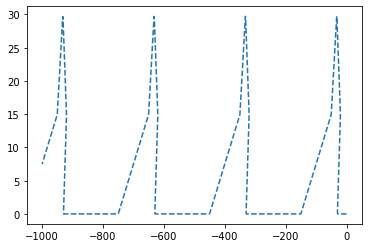

In [3]:
L_x, L_p, x2, x3, x4, x5, h = 1000, 300, -32, -30, -50, -20, 30
x1 = -0.5*L_p
N_s = 1001

L_p, x2, x3, x4, x5, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(x4, dtype=torch.float), torch.tensor(x5, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")
# plt.xlim([-1000,-600])
# ##################################################
# # Prediction on a special design
# #################################################
# model = torch.load("catheter_plain_period_model_1d500", map_location=device)
# out = torch.clip(model(X_Y).squeeze(), min=0.0).detach().cpu().numpy()
# xx_mask = numpy.linspace(1.0, 0, n_periods*ncx+1) * (-L_p*n_periods)
# print("L_p, x1, x2, x3, h  = ", L_p, x1, x2, x3, h)
# print("loss = ",  -np.dot(out,xx_mask) )
# plt.figure()
# plt.plot(xx_mask, out)


1336001
initialize :  (tensor(100., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<MulBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(-50., grad_fn=<AddBackward0>), tensor(-30., grad_fn=<AddBackward0>), tensor(25., grad_fn=<AddBackward0>))
0 0.026843871921300888 loss =  531229.1875
L_p, x1, x2, x3, x4, x5, h  =  100.0 -50.0 -30.0 -30.0 -50.0 -30.0 25.0


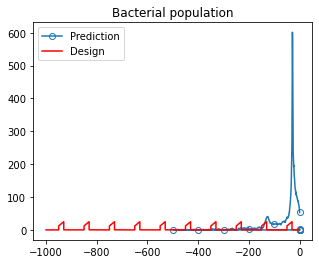

200 0.012494747992604971 loss =  449199.9375
L_p, x1, x2, x3, x4, x5, h  =  91.62371063232422 -45.81185531616211 -22.905384063720703 -26.275516510009766 -49.178001403808594 -30.871583938598633 25.703088760375977


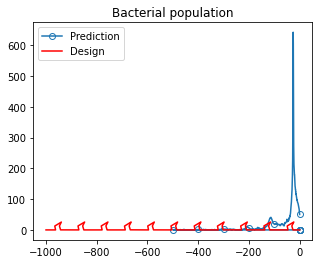

400 0.013113745953887701 loss =  371572.78125
L_p, x1, x2, x3, x4, x5, h  =  84.1270751953125 -42.06353759765625 -16.779399871826172 -23.08295249938965 -48.30712127685547 -31.268949508666992 26.347248077392578


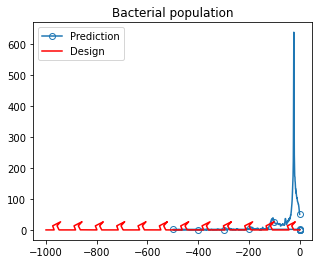

600 0.012345661409199238 loss =  337066.84375
L_p, x1, x2, x3, x4, x5, h  =  78.40367126464844 -39.20183563232422 -12.523309707641602 -20.88098907470703 -47.458656311035156 -31.21729278564453 26.884342193603516


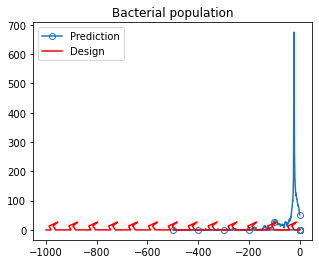

800 0.023205779027193785 loss =  237480.859375
L_p, x1, x2, x3, x4, x5, h  =  73.63817596435547 -36.819087982177734 -9.531379699707031 -19.19740104675293 -46.27235412597656 -30.520292282104492 27.281404495239258


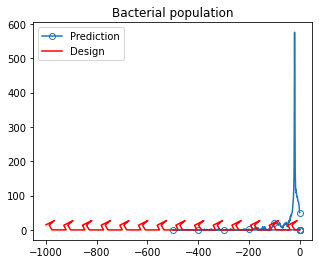

1000 0.012604853138327599 loss =  287426.71875
L_p, x1, x2, x3, x4, x5, h  =  70.46375274658203 -35.231876373291016 -7.428438186645508 -18.118637084960938 -45.52055740356445 -30.043411254882812 27.556087493896484


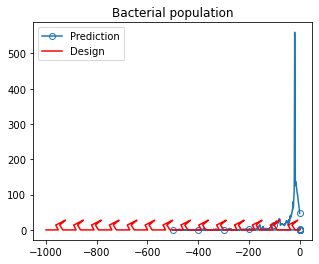

1200 0.03338359575718641 loss =  286168.65625
L_p, x1, x2, x3, x4, x5, h  =  70.20439910888672 -35.10219955444336 -7.259147644042969 -18.032814025878906 -45.45598602294922 -29.998964309692383 27.57657241821289


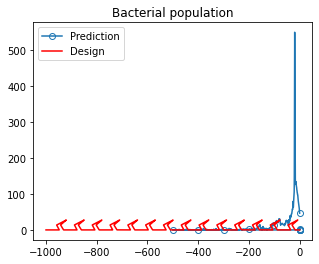

1400 0.02297228155657649 loss =  285739.65625
L_p, x1, x2, x3, x4, x5, h  =  69.95865631103516 -34.97932815551758 -7.100032806396484 -17.95193099975586 -45.39391326904297 -29.955589294433594 27.594297409057617


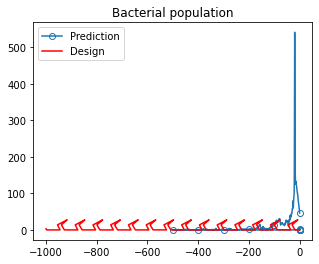

1600 0.033334326930344105 loss =  286693.25
L_p, x1, x2, x3, x4, x5, h  =  69.7343978881836 -34.8671989440918 -6.948169708251953 -17.87809944152832 -45.34487533569336 -29.923728942871094 27.610244750976562


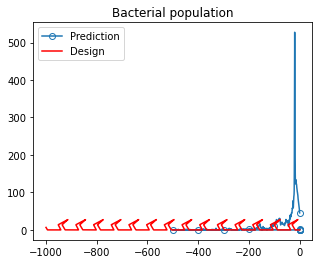

1800 0.022889599669724703 loss =  287899.5625
L_p, x1, x2, x3, x4, x5, h  =  69.53094482421875 -34.765472412109375 -6.802036285400391 -17.810964584350586 -45.31157684326172 -29.90631866455078 27.6248779296875


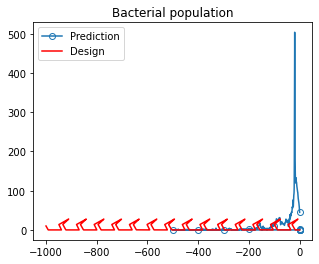

2000 0.02300508413463831 loss =  289111.4375
L_p, x1, x2, x3, x4, x5, h  =  69.34504699707031 -34.672523498535156 -6.660943984985352 -17.749431610107422 -45.29188919067383 -29.901376724243164 27.636905670166016


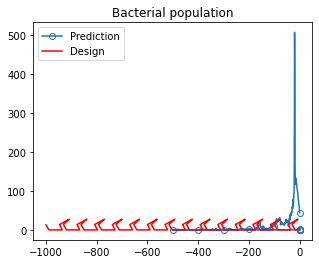

2200 0.023260468617081642 loss =  289199.03125
L_p, x1, x2, x3, x4, x5, h  =  69.3274917602539 -34.66374588012695 -6.647056579589844 -17.74359703063965 -45.29087448120117 -29.901769638061523 27.637737274169922


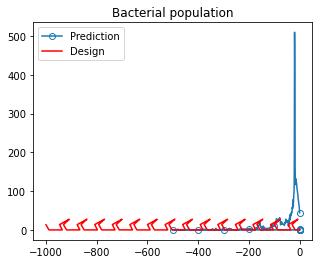

2400 0.025019918102771044 loss =  289280.90625
L_p, x1, x2, x3, x4, x5, h  =  69.3104248046875 -34.65521240234375 -6.633264541625977 -17.73790740966797 -45.29037094116211 -29.90264320373535 27.6380672454834


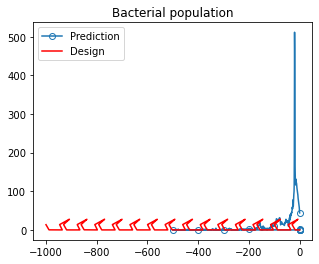

2600 0.024519445840269327 loss =  289364.625
L_p, x1, x2, x3, x4, x5, h  =  69.2936782836914 -34.6468391418457 -6.619647979736328 -17.732309341430664 -45.29021072387695 -29.903841018676758 27.637775421142578


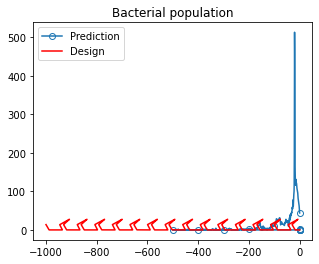

2800 0.03383754985406995 loss =  280708.71875
L_p, x1, x2, x3, x4, x5, h  =  69.27613067626953 -34.638065338134766 -6.605897903442383 -17.726476669311523 -45.2892951965332 -29.904314041137695 27.63652801513672


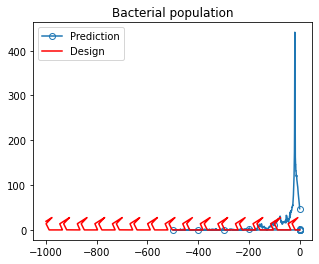

3000 0.03650630032643676 loss =  280532.59375
L_p, x1, x2, x3, x4, x5, h  =  69.25627899169922 -34.62813949584961 -6.591770172119141 -17.719980239868164 -45.28620910644531 -29.902711868286133 27.633834838867188


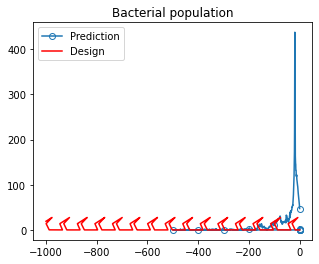

3200 0.01256326911970973 loss =  280513.75
L_p, x1, x2, x3, x4, x5, h  =  69.25418090820312 -34.62709045410156 -6.590333938598633 -17.71929931640625 -45.285736083984375 -29.902395248413086 27.633424758911133


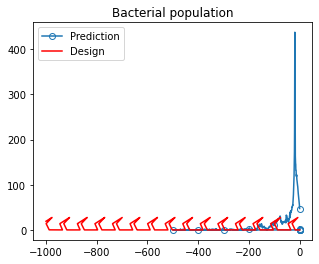

3400 0.02840380184352398 loss =  280496.09375
L_p, x1, x2, x3, x4, x5, h  =  69.25208282470703 -34.626041412353516 -6.588901519775391 -17.718618392944336 -45.28526306152344 -29.902076721191406 27.632915496826172


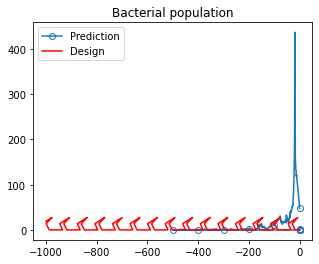

3600 0.03377711772918701 loss =  280473.53125
L_p, x1, x2, x3, x4, x5, h  =  69.24958801269531 -34.624794006347656 -6.58741569519043 -17.717823028564453 -45.28443908691406 -29.901426315307617 27.632356643676758


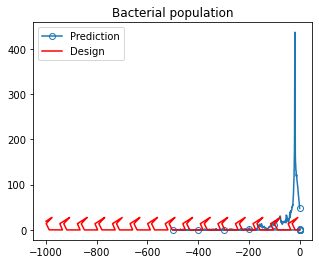

3800 0.023182725999504328 loss =  280450.71875
L_p, x1, x2, x3, x4, x5, h  =  69.2470703125 -34.62353515625 -6.585926055908203 -17.717018127441406 -45.28356170654297 -29.900720596313477 27.631797790527344


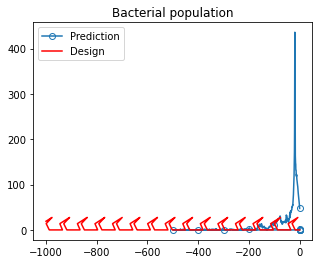

4000 0.02378101972863078 loss =  280427.90625
L_p, x1, x2, x3, x4, x5, h  =  69.24456024169922 -34.62228012084961 -6.584442138671875 -17.716217041015625 -45.28268814086914 -29.900020599365234 27.631237030029297


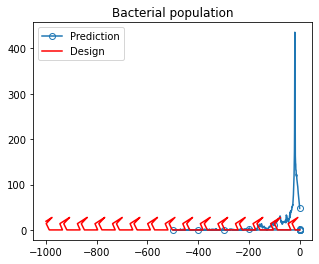

4200 0.028508630581200123 loss =  280423.4375
L_p, x1, x2, x3, x4, x5, h  =  69.244140625 -34.6220703125 -6.584257125854492 -17.71608543395996 -45.28254318237305 -29.899900436401367 27.631193161010742


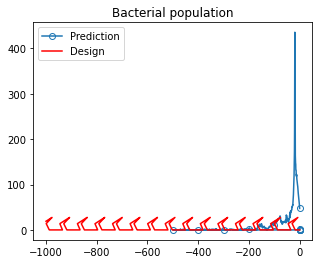

4400 0.02624691417440772 loss =  280418.875
L_p, x1, x2, x3, x4, x5, h  =  69.24372100830078 -34.62186050415039 -6.584070205688477 -17.715953826904297 -45.28229522705078 -29.899677276611328 27.631149291992188


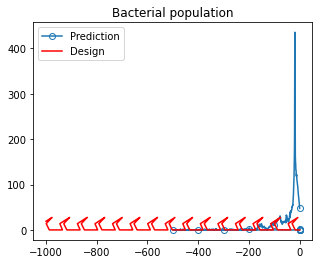

4600 0.012887118849903345 loss =  280414.0
L_p, x1, x2, x3, x4, x5, h  =  69.24330139160156 -34.62165069580078 -6.583887100219727 -17.715824127197266 -45.282020568847656 -29.89942741394043 27.631107330322266


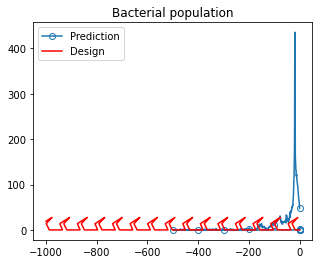

4800 0.012588255107402802 loss =  280409.40625
L_p, x1, x2, x3, x4, x5, h  =  69.24288177490234 -34.62144088745117 -6.583700180053711 -17.7156925201416 -45.28174591064453 -29.89917755126953 27.63106346130371


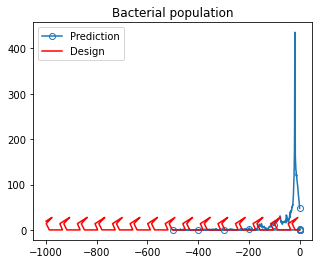

In [ ]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
print(count_params(model))


learning_rate = 0.001
epochs = 5001
step_size = 1000
gamma = 0.1


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/4
#           -L_p/4 < x2 - x3 < L_p/4
#               20 < h  < 30
#           -L_p/4 < x4 - x1 < L_p/4    
#               15 < x5 - x4 < L_p/4
#
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[2]))
    x2 = x3  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[1]))
    #
    x4 = x1  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[4]))
    x5 = x4  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[5]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, x4, x5, h


def inv_transfer(L_p, x2, x3, x4, x5, h):
    x1 = -0.5*L_p
    theta = np.zeros(6)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( (L_p/2)/(x2 - x3  + L_p/4) - 1 )
    theta[2] = np.log( (L_p/4 - 15)/(x3 - x1  - 15) - 1 )
    
    theta[4] = np.log( (L_p/2)/(x4 - x1  + L_p/4) - 1 )
    theta[5] = np.log( (L_p/4 - 15)/(x5 - x4  - 15) - 1 )    
    
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta


L_p, x2, x3, x4, x5, h = 100.0, -30.0, -30.0, -50.0, -30.0, 25.0, 

theta0 =    inv_transfer(L_p, x2, x3, x4, x5, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 1000
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
xx_mask[0:1000] = 0.0
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, x4, x5, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, x4, x5, h, N_s)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, x4, x5, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), x4.item(), x5.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

In [5]:
################################################################
# inverse optimization for 1d
################################################################


model = torch.load("catheter_plain_length_model_1d500", map_location=device)
print(count_params(model))

learning_rate = 0.001
epochs = 2001
step_size = 1000
gamma = 0.1


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               -L_p/4 < x2 - x1 < L_p/4
#               15 < x3 - x1 < L_p/4
#               20 < h < 30
# def transfer(theta):
    
#     L_p = 60 + (250 - 60)/(1 + torch.abs(theta[0]))
#     x1 = -0.5*L_p
#     x2 = x1  - L_p/4 + (L_p/2)/(1 + torch.abs(theta[1]))
#     x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.abs(theta[2]))
#     h = 20   + (10)/(1 + torch.abs(theta[3]))
#     return L_p, x1, x2, x3, h

# def inv_transfer(L_p, x2, x3, h):
#     x1 = -0.5*L_p
#     theta = np.zeros(4)
#     theta[0] = (250 - 60)/(L_p - 60) - 1
#     theta[1] = (L_p/2)/(x2 - x1  + L_p/4) - 1
#     theta[2] = (L_p/4 - 15)/(x3 - x1  - 15) - 1
#     theta[3] = 10/(h - 20 ) - 1
#     return theta


# constraints   
#               60 < L_p < 250
#               x1 = -0.5L_p 
#               
#               15 < x3 - x1 < L_p/4
#.          -L_p/4 < x2 - x3 < L_p/4
#               20 < h < 30
# def transfer(theta):
def transfer(theta):
    
    L_p = 60 + (250 - 60)/(1 + torch.exp(theta[0]))
    x1 = -0.5*L_p
    x3 = x1  + 15 + (L_p/4 - 15)/(1 + torch.exp(theta[2]))
    x2 = x3  - L_p/4 + (L_p/2)/(1 + torch.exp(theta[1]))
    h = 20   + (10)/(1 + torch.exp(theta[3]))
    return L_p, x1, x2, x3, h


def inv_transfer(L_p, x2, x3, h):
    x1 = -0.5*L_p
    theta = np.zeros(4)
    theta[0] = np.log( (250 - 60)/(L_p - 60) - 1 )
    theta[1] = np.log( (L_p/2)/(x2 - x3  + L_p/4) - 1 )
    theta[2] = np.log( (L_p/4 - 15)/(x3 - x1  - 15) - 1 )
    theta[3] = np.log( 10/(h - 20 ) - 1 )
    return theta

sample, uf, L_p, x1, x2, x3, h = inputPara[:, loss_min_ind]
# L_p, x2, x3, h = 80.0, -22.0, -22.0, 28.0
# L_p, x2, x3, h = 100.0, -30.0, -30.0, 25.0

theta0 =    inv_transfer(L_p, x2, x3, h) 


theta = torch.tensor(theta0.astype(np.float32) , requires_grad=True)
print("initialize : ", transfer(theta))

optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)


L_x = 1000
N_s = 2001
xx_mask = (torch.linspace(1.0, 0, N_s) * (-L_x)).to(device)
    
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    L_p, x1, x2, x3, h = transfer(theta)
    x, XC, YC = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
    
    out = torch.clip(model(x).squeeze(), min=0.0)
    # maximize negative mean
    loss = -torch.sum(torch.matmul(out, xx_mask))* L_x/N_s
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    
    if ep%200==0:
        print(ep, t2 - t1,  "loss = ", loss.item())

        mesh = x.detach().cpu().numpy()
        print("L_p, x1, x2, x3, h  = ", L_p.item(), x1.item(), x2.item(), x3.item(), h.item())
        plt.figure(figsize=(5,4))
        plt.title("Bacterial population")
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy().T, "-o", fillstyle='none', markevery=len(xx_mask)//10, label="Prediction")
        plt.plot(mesh[0, :, 0], mesh[0, :, 1], color="r", label="Design")
        
        plt.legend()
        plt.show()
#         plt.savefig("Catheter."+str(ep).zfill(5)+".pdf")

1336001


NameError: name 'inputPara' is not defined